In [150]:
#-*- coding: utf-8 -*-
%matplotlib inline

import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import MySQLdb
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
import statsmodels.tsa.stattools as st

from numpy.polynomial import polynomial as P

## 作业一 


### 爬取数据 存入mysql

In [3]:
# 连接mysql
conn = MySQLdb.connect(host='localhost',user='root',passwd='920205',db='securities_master',charset='utf8')

In [4]:
# 爬取股票代码并存入mysql
indicator_table = ts.get_hs300s()
cur = conn.cursor()
cur.execute("drop table if exists symbol")
indicator_table.to_sql("symbol",conn,flavor="mysql")


/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:4: Warning: Unknown table 'symbol'
/home/ata/.virtualenvs/spider/local/lib/python2.7/site-packages/pandas/core/generic.py:1165: FutureWarning: The 'mysql' flavor with DBAPI connection is deprecated and will be removed in future versions. MySQL will be further supported with SQLAlchemy connectables.
  chunksize=chunksize, dtype=dtype)
/home/ata/.virtualenvs/spider/local/lib/python2.7/site-packages/pandas/io/sql.py:1445: Warning: Incorrect string value: '\xE6\xAC\xA7\xE8\x8F\xB2...' for column 'name' at row 1
  conn.executemany(self.insert_statement(), data_list)
/home/ata/.virtualenvs/spider/local/lib/python2.7/site-packages/pandas/io/sql.py:1445: Warning: Incorrect string value: '\xE4\xBF\xA1\xE5\xA8\x81...' for column 'name' at row 2
  conn.executemany(self.insert_statement(), data_list)
/home/ata/.virtualenvs/spider/local/lib/python2.7/site-packages/pandas/io/sql.py:1445: Warning: Incorrect string value: 

In [5]:
# 爬取股票信息 将每一支股票信息存入一张表中
for item in indicator_table["code"]:
    his_stock = ts.get_hist_data(item,start='2010-01-01',end='2016-01-01')
    his_stock["symbol_id"] = item # 加入股票代码列
    his_stock["variation"] = his_stock["close"] - his_stock["open"] #加入每日价格变动列
    sql = "drop table if exists price_" + item
    cur.execute(sql)
    his_stock.to_sql("price_"+item,conn,flavor = "mysql")

/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_002456'
/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_600485'
/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_002008'
/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_600208'
/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_002153'
/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_002241'
/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_300002'
/home/ata/.virtualenvs/spider/lib/python2.7/site-packages/ipykernel/__main__.py:7: Warning: Unknown table 'price_002475'
/home/ata/.virtualenvs/spider/li

In [170]:

var = pd.DataFrame() # 将所有股票交易日价格变动放入一张表中
open_price = pd.DataFrame() # 将所有股票交易日开盘价放入一张表中
close_price = pd.DataFrame() # 将所有股票交易日收盘价放入一张表中

for item in indicator_table["code"]:
    his_stock = ts.get_hist_data(item,start='2010-01-01',end='2016-01-01')
    open_price[item] = his_stock["open"]
    close_price[item] = his_stock["close"]
    var[item] = his_stock["open"] - his_stock["close"]
    
var = var.fillna(0.0000000000001) # 将价格变动表中空缺值用极小值补全，如果用0再后面做检验的时候会报错。
open_price = open_price.fillna(method = "ffill")
open_price = open_price.fillna(method = "bfill")
close_price = close_price.fillna(method = "ffill")
close_price = close_price.fillna(method = "bfill")

sql_1 = "drop table if exists open_price"
sql_2 = "drop table if exists close_price"
sql_3 =  "drop table if exists stock"


cur.execute(sql_1)
cur.execute(sql_2)
cur.execute(sql_3)


open_price.to_sql("open_price",conn,flavor = "mysql")
close_price.to_sql("close_price",conn,flavor = "mysql")
stock.to_sql("stock",conn,flavor = "mysql")


## 作业二

### 对股票进行聚类并画图

In [125]:
x = var/var.std(0)
edge_model = covariance.GraphLassoCV()
edge_model.fit(x)
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
names = np.array([indicator_table[indicator_table["code"]== k]["name"].values[0] for k in stock.columns.values])
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: 信威集团
Cluster 2: 欧菲光, 大族激光, 歌尔股份, 九州通, 梅花生物, 同方股份, 万向钱潮, 比亚迪, 中航资本, 鹏博士, 浪潮信息, 海普瑞
Cluster 3: 新湖中宝
Cluster 4: 神州泰岳
Cluster 5: 立讯精密
Cluster 6: 海澜之家
Cluster 7: 节能风电
Cluster 8: 恒生电子, 二三四五, 金证股份, 东方财富
Cluster 9: 际华集团, 中粮屯河
Cluster 10: 大北农, 新 希 望
Cluster 11: 奥飞娱乐
Cluster 12: 上汽集团, 华域汽车, 宇通客车, 燕京啤酒, 长安汽车, 一汽轿车
Cluster 13: 中国铁建, 中国交建, 中国中铁
Cluster 14: 人民网, 蓝色光标
Cluster 15: 万达院线
Cluster 16: 浙江龙盛
Cluster 17: 分众传媒
Cluster 18: 新兴铸管
Cluster 19: 江苏有线
Cluster 20: 金 螳 螂
Cluster 21: 苏宁云商, 机器人, 永辉超市, 汇川技术, 爱尔眼科
Cluster 22: 安信信托, 隧道股份, 绿地控股, 鲁信创投, 广州发展, 上海建工, 物产中大
Cluster 23: 吉林敖东, 辽宁成大, 广发证券, 锦龙股份, 太平洋, 华泰证券, 国海证券, 西南证券, 东北证券, 兴业证券, 渤海金控, 海通证券, 光大证券, 方正证券, 雅戈尔, 国金证券, 中信证券, 山西证券, 西部证券, 长江证券, 国投安信, 招商证券, 东吴证券, 泛海控股, 国元证券
Cluster 24: 招商蛇口
Cluster 25: 宁波银行, 南京银行, 北京银行, 华夏银行, 兴业银行, 中信银行, 浦发银行, 民生银行, 招商银行, 光大银行, 平安银行
Cluster 26: 网宿科技
Cluster 27: 国投电力, 长江电力
Cluster 28: 中天城投
Cluster 29: 中国核电, 国泰君安, 中国国旅, 吉祥航空
Cluster 30: 万达信息
Cluster 31: 华闻传媒
Cluster 32: 贵州百灵
Cluster 33: 首开股份, 华侨城Ａ, 金地集团, 金 融 街, 万 科Ａ

In [87]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=5)

embedding = node_position_model.fit_transform(x.T).T

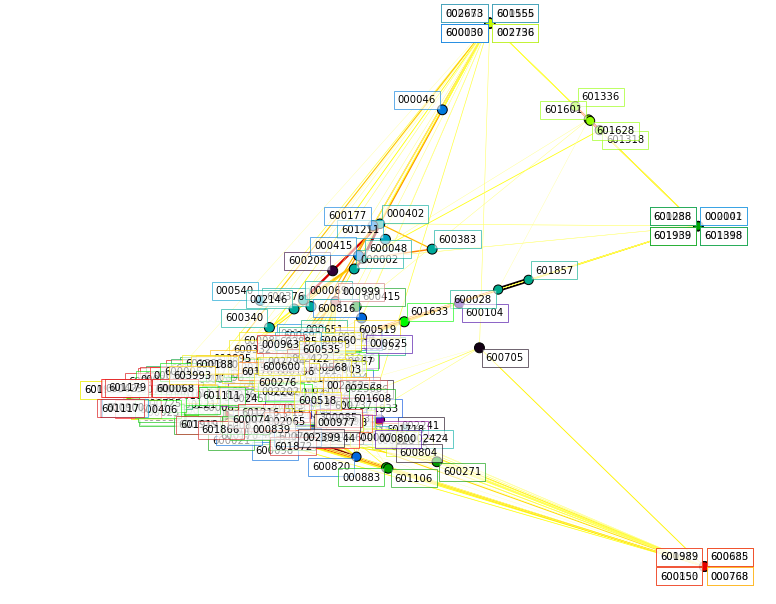

In [92]:
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')
names =  stock.columns.values

partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)


plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)


start_idx, end_idx = np.where(non_zero)

segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (a, b)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = a - embedding[0]
    dx[index] = 1
    dy = b - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        a = a + .002
    else:
        horizontalalignment = 'right'
        a = a - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        b = b + .002
    else:
        verticalalignment = 'top'
        b = b - .002
    plt.text(a, b, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

## 作业三

### 平稳性检验(ADF Test & Hurst Exponent)

In [155]:
# 定义Hurst函数
def hurst(ts):
    # create the range of lag values
    lags = range(2,100)
    # calculate the array of the variance of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:],ts[:-lag]))) for lag in lags]
    # use a linear fit to estimate the hurst exponent
    poly =np.polyfit(np.log(lags),np.log(tau),1)
    # return the hurst exponent from the polyfit output
    return poly[0]*2.0

In [168]:
adf_stock = []
hurst_stock = []
for i in stock.columns.values:
    if st.adfuller(close_price[i])[4]["10%"] <= -3.35875: # 0.1的显著性水平下的检验，将拒绝原假设的股票代码记录下来
        adf_stock.append(i)
    if hurst(close_price[i]) < 0.5: # H < 0.5 代表趋势结束和反转的开始
        hurst_stock.append(i)

## 作业四

### 

In [193]:
pairs = []
names = []
for i in range(300):
    for j in range(i+1,300):
        x = close_price[stock.columns.values[i]]
        y = close_price[stock.columns.values[j]]
        p = st.coint(x,y)[1]
        if p < 0.01:
            pairs.append([indicator_table["code"][i],indicator_table["code"][j]])
            names.append([indicator_table["name"][i],indicator_table["name"][j]])